# ASTR 1040 Imaging Workshop

## Setup instructions:

1. Make sure you have downloaded the FITS (image) files for your observation, and that you're running this notebook from the same folder that has these files! Probably best to put this notebook + files for the observation you want to make a picture of in a separate folder. Also make sure you have the `makeImg.jl` script downloaded in this same folder.

2. Make sure you have Julia (v>1.5) [installed](https://julialang.org/downloads/) with the [IJulia package also installed](https://datatofish.com/add-julia-to-jupyter/) so that you can actually run this notebook!

3. Install the following Julia packages: `Plots, FITSIO, DataFrames, Statistics, StatsBase, Images, FileIO` &mdash; you can install packages by entering a Julia terminal (launch Julia from start menu or type it at the command line) and pushing the `]` key to get to the package manager, then you simply type `add Plots` for example to add the Plots package. More detailed instructions [here](https://docs.julialang.org/en/v1/stdlib/Pkg/).

# Part 1: Reading in the data

Before we can get started we first need to read in the data! The cell below should read in the FITS files in this directory and display a nice table summarizing some important information contained in each file. Run it and make sure it works!

In [1]:
using Plots, FITSIO, DataFrames
files = filter(endswith(".fits"),readdir()) #readdir() creates a list of files in the current directory, which we then `filter` to find only those that end with ".fits" since those are our images!
test = FITS(files[10]) #let's see what one is like
df = DataFrame(file = String[], filter = String[], exposure = Float64[]) #initialize an empty "DataFrame" (basically a fancy table) with keys "file", "filter", and "exposure" with types String, String, and Float64
for f in files #iterate through every one of our files
    header = read_header(FITS(f)[1]) #read the header of the current file
    push!(df, [f, header["FILTER"], header["EXPOSURE"]]) #add the info to our fancy table
end
df #display the table 

13×3 DataFrame
 Row │ file                             filter  exposure 
     │ String                           String  Float64  
─────┼───────────────────────────────────────────────────
   1 │ 00000010.BIAS.fixed_header.fits  Halpha       0.0
   2 │ 00000011.BIAS.fixed_header.fits  Halpha       0.0
   3 │ 00000012.BIAS.fixed_header.fits  Halpha       0.0
   4 │ 00000043.FLAT.fixed_header.fits  Clear        4.0
   5 │ 00000044.FLAT.fixed_header.fits  Clear        4.0
   6 │ 00000045.FLAT.fixed_header.fits  Clear        4.0
   7 │ 00000064.DARK.fixed_header.fits  Clear      300.0
   8 │ 00000065.DARK.fixed_header.fits  Clear      300.0
   9 │ 00000066.DARK.fixed_header.fits  Clear      300.0
  10 │ 00000075.fixed_header.fits       Clear      300.0
  11 │ 00000077.fixed_header.fits       Red        300.0
  12 │ 00000078.fixed_header.fits       Green      300.0
  13 │ 00000079.fixed_header.fits       Blue       300.0

In this example we can see that we have three "bias" images taken in H$\alpha$, three "flat" images taken without a filter, three "dark" images taken without a filter, and four actual images with 300s exposure times taken in r,g,b filters as well as without a filter. We're going to combine these in fancy ways (based on statistics nonsense) but before we do that we should check out what "type" our data is to make sure it's numerically stable. Run the cell below to do this!

In [2]:
images = []; imageType = typeof(test[1]) #initialize empty images list, get the type of an image from our "test" sample above -- ImageHDU
for f in files #loop through all the fits files
    fits = FITS(f) #get the data from FITSIO
    for hdu in fits #iterate through the different "header data units" in each fits 
        if typeof(hdu) == imageType #is it an image?
            push!(images,read(hdu)) #plop it in our images list if the type matches!
        end
    end
end
println("image data is of type: ",typeof(images[1][1,1])) #what is the data type used in the images?
counter = 1
for im in images
    println("(min,max) of image corresponding to file $counter = ($(minimum(im)),$(maximum(im)))") #biggest uInt16 is 65536 (2^16) before it wraps, and likewise no numbers less than 0 are possible, so let's check the values
    #in julia we can inject code into a print call using the $ interpolation syntax, which is then evaluated during the call to print. We can also use formatting strings like in Python/other languages if you prefer.
    counter+=1
end
#UInt16 is bad and can wrap easily (as I have now experienced first hand), so gonna promote to Int32 here
images = [Int32.(images[i]) for i=1:length(images)]; #this changes the type of our data to make it more "stable" when we add/subtract/divide/multiply etc.

image data is of type: UInt16
(min,max) of image corresponding to file 1 = (48,449)
(min,max) of image corresponding to file 2 = (48,451)
(min,max) of image corresponding to file 3 = (48,447)
(min,max) of image corresponding to file 4 = (11993,24614)
(min,max) of image corresponding to file 5 = (11168,23358)
(min,max) of image corresponding to file 6 = (10596,22399)
(min,max) of image corresponding to file 7 = (44,47769)
(min,max) of image corresponding to file 8 = (49,47855)
(min,max) of image corresponding to file 9 = (50,47707)
(min,max) of image corresponding to file 10 = (349,57134)
(min,max) of image corresponding to file 11 = (100,53013)
(min,max) of image corresponding to file 12 = (108,53055)
(min,max) of image corresponding to file 13 = (72,46778)


The output of the cell above shows us that the "raw" data had the type "UInt16" &mdash; this means it was originally stored as an "unsigned 16-bit integer". While this is fine for the CCD, this is bad for us because this number type is not numerically stable &mdash; numbers in this data format must always be less than $2^{16}$ = 65536 and can't be smaller than 0. If you break this rule in this data type the number will "wrap" around &mdash; ie if you did 0-1 and both were UInt16 the computer would spit out 65535, which is obviously nonsense! We can see we were potentially in danger of errors like this happening as the minimum values are close to zero and some of the maximum values are close to that upper limit, so at the end of the cell I converted all of the data to the Int32 type, which should be fine for our use.

Now we're ready to actually look at an image. Let's start by looking at the first raw clear image, which according to our table should be image 10. The cell below will make a pretty picture showing us what's in there!

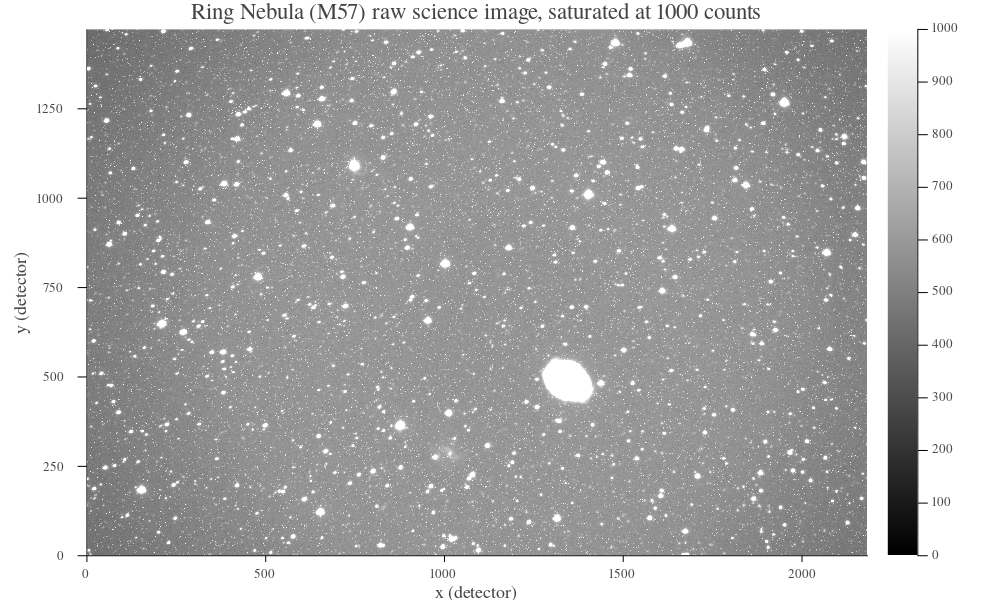

In [3]:
#let's look at image 10, as according to the header file this one is an actual exposure without a filter
gr(format=:png); default(fontfamily="times",widen=false,tickdirection=:out) #let's set some nice default formatting options for all our plots
raw = heatmap(images[10]',c=:bone,aspect_ratio=:equal,clim=(0,1000),xlabel="x (detector)",ylabel="y (detector)",
    title = "Ring Nebula (M57) raw science image, saturated at 1000 counts",grid=false,
    xlims=(0,size(images[10])[1]),ylims=(0,size(images[10])[2])) #heatmap is a built-in plotting function in Julia designed to plot 2D data with intensity of color ("heat") corresponding to value at each point
#we had to use the transpose of the data (images[10]') because the data is formatted (in x and y) opposite how Julia expects it (you can try removing the transpose operator to see what it does, it's really just to get the image in the "right" orientation). 
#other things: c=:bone means use the "bone" colormap, aspect_ratio=:equal means make the x and y axes scale the same, clim=(0,1000) means the plot is "saturated" at 1000 counts, the xlabel,ylabel,and title keys set those corresponding plot attributes,
#we turn the grid off because we want to just see the pretty picture, and we set the x/y limits according to how big the data was in the x and y directions (ie size(images[10])[1] returns the size of the 10th thing in our image list along the x direction)
plot(raw,size=(1000,600)) #display the plot, resizing it to be nice and big and pretty

# Part 2: Reducing the data

We can definitely tell this is the ring nebula, but obviously there's a lot of residual noise we should try to get rid of. The next cell will make a "reduced" image that should be much cleaner, and to do this we'll do some fancy statistics with the "dark", "flat", and "bias" images. The cell below takes a few seconds to run, but spits out a pretty array of plots at the end comparing the results of "reducing" the images to the raw images!

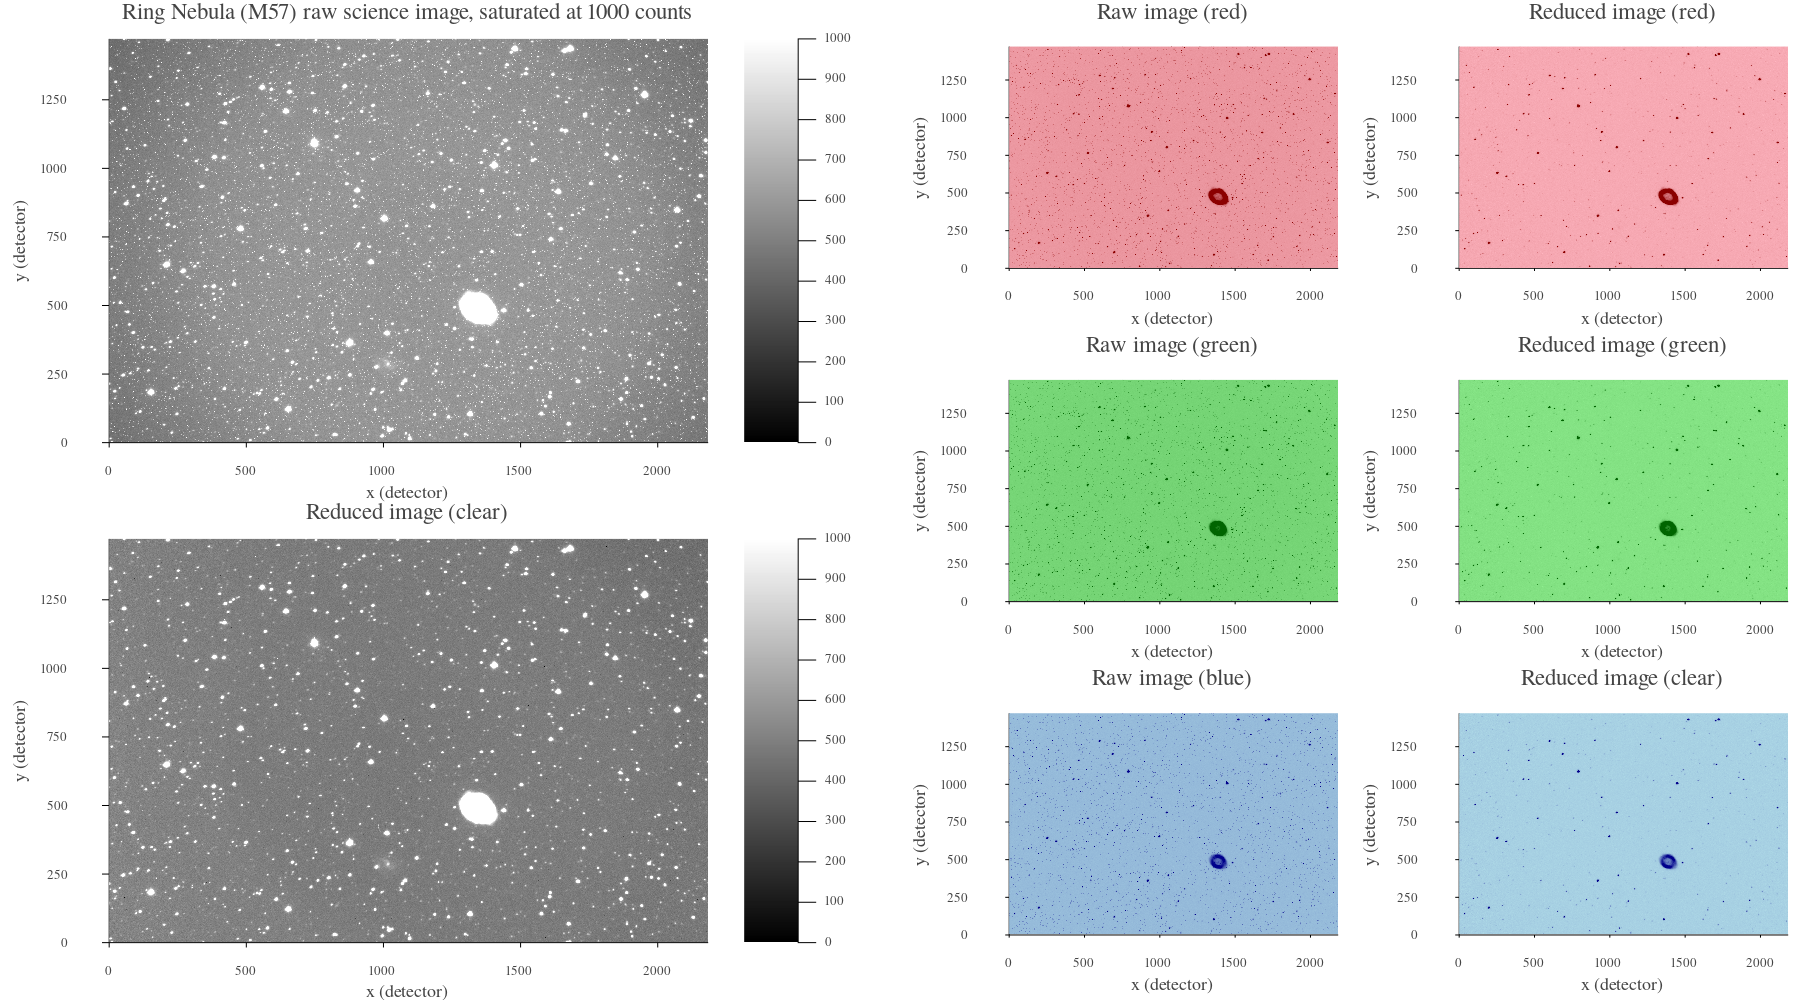

In [4]:
using Statistics #now we're going to do some math, gross
darkImgs = images[7:9] #according to our table from before these ones were the "dark" frames
darkMaster = zeros(size(darkImgs[1])) #let's initialize an array for our "master" dark frame that's the same size as the existing dark images
for i=1:size(darkMaster)[1] #iterate through every x possibility
    for j=1:size(darkMaster)[2] #iterate through every y possibility
        darkMaster[i,j] = median([darkImgs[1][i,j],darkImgs[2][i,j],darkImgs[3][i,j]]) #the "master" frame at position x,y (i,j) should be the median of the three initial dark frames at that same position
    end
end

#now let's do something similar for our bias images
biasImgs = images[1:3] #according to our table the first 3 were the bias images
biasMaster = zeros(size(biasImgs[1])) #again we initialize an empty 2D array for our bias "master" that's the same size as one of the existing images
for i=1:size(biasMaster)[1] #iterate through x
    for j=1:size(biasMaster)[2] #and y
        biasMaster[i,j] = median([biasImgs[1][i,j],biasImgs[2][i,j],biasImgs[3][i,j]]) #again we set the master value at each x,y position to be the median of the three provided frames
    end
end

#and we'll do something slightly more complicated for the flat images
using StatsBase #I guess Statistics doesn't have mode so we need to use this other package?
flatImgs = [images[i] .- biasMaster for i=4:6] #images 4-6 are the "flat" images, and we are subtracting the bias from them here
flatImgs = flatImgs./(maximum(mode.(flatImgs))) #now we divide all of them by the maximum mode between them to rescale
normFlatMaster = zeros(size(flatImgs[1])) #we again preallocate a matching 2D array that will be our "normalized flat master" image
for i=1:size(normFlatMaster)[1] #loop x
    for j=1:size(normFlatMaster)[2] #and y
        normFlatMaster[i,j] = median([flatImgs[1][i,j],flatImgs[2][i,j],flatImgs[3][i,j]]) #again we now set the x,y position of our master to be the median of the three existing images
    end
end
normFlatMaster = normFlatMaster./mode(normFlatMaster) #finally we normalize the flat master by the most often occuring value (mode)

#now we're ready to make our reduced images!
M57Imgs = images[10:13] #from our table at the beginning we know these are the actual raw images of the ring nebula
M57Reduced = [(M57Imgs[i] .- darkMaster)./normFlatMaster for i=1:length(M57Imgs)]; #to "reduce" the images we subtract our dark master and then divide by our normalized flat master
#the code below isto make the plotting easier, so we can see what they look like!
function makeImg(img,Title,cBar=true,c=:bone,labelx=true,labely=true,cMax=1000) #this generalizes the plotting process so we don't have to type all this out so much
    xlabel = labelx==true ? "x (detector)" : ""; ylabel = labely==true ? "y (detector)" : ""
    p=heatmap(img',c=c,aspect_ratio=:equal,xlabel=xlabel,ylabel=ylabel,
    title = Title,grid=false,clims=(0,cMax),
    xlims=(0,size(img)[1]),ylims=(0,size(img)[2]),colorbar=cBar)
    return p
end
#below we generate the plots in each of the different filters with corresponding titles, and we will compare the reduced images to the raw ones
clear = makeImg(M57Reduced[1],"Reduced image (clear)"); red = makeImg(M57Reduced[2],"Reduced image (red)",false,:reds) 
green = makeImg(M57Reduced[3],"Reduced image (green)",false,:greens); blue = makeImg(M57Reduced[4],"Reduced image (clear)",false,:blues)
redRaw = makeImg(images[11],"Raw image (red)",false,:reds); greenRaw = makeImg(images[12],"Raw image (green)",false,:greens)
blueRaw = makeImg(images[13],"Raw image (blue)",false,:blues)

using Plots.Measures #allows me to specify things in mm
#let's make a fancy layout to show all our plots
l = @layout [
    grid(2,1) grid(3,2)
]
p = plot(raw,clear,redRaw,red,greenRaw,green,blueRaw,blue,layout=l,size=(1800,1000),link=:all,left_margin=10mm,botom_margin=5mm) #link argument appears to be broken, whatever
plot(p)

# Part 3: Making a color image

Now that we have our cleaned up images, we just need to combine the red, green, and blue channels to make a simple color image! There is a small problem, however &mdash; the filtered images are not perfectly lined up with one another. Let's try combining them up as they are and see how bad it looks...

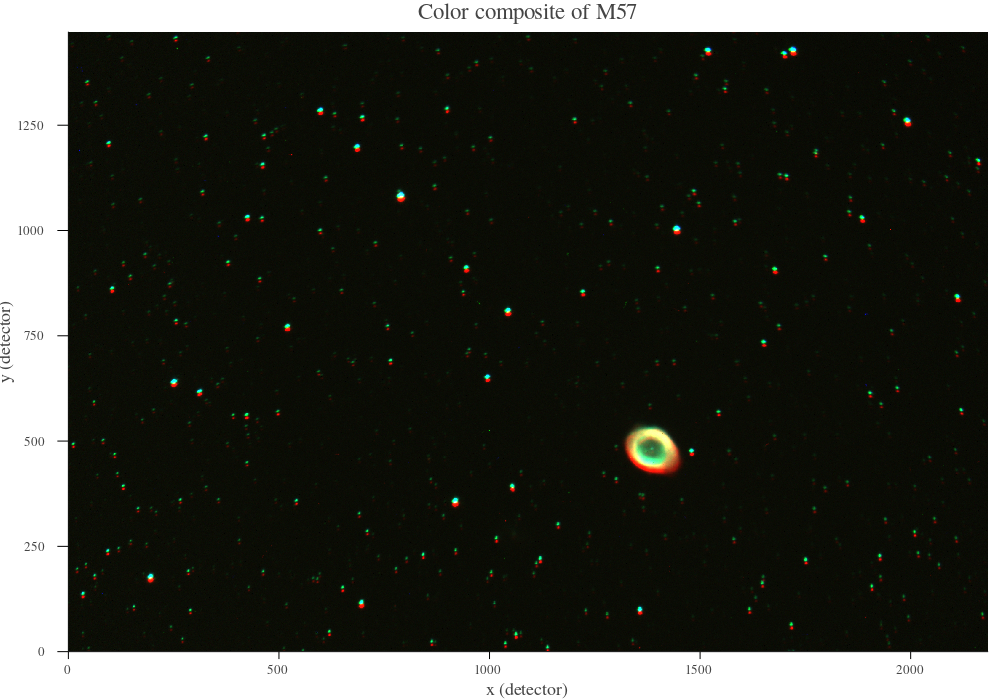

In [5]:
using Images #this package will allow us to save the r,g,b data as an actual picture!
r,g,b = [M57Reduced[i] for i=2:4] 
newImg = zeros(3,size(r)[2],size(r)[1]) #rgb,y,x -- needs to be set up in the way Images wants it
for i=1:size(newImg)[1]
    for j=1:size(newImg)[3] 
        for k=1:size(newImg)[2] #k,j swap rotates below
            if i==1
                newImg[i,k,j]= r[j,k] #red channel
            elseif i==2
                newImg[i,k,j]= g[j,k]#green channel
            else
                newImg[i,k,j]= b[j,k]#blue channel
            end
        end
    end
end
newImg = newImg./(maximum(newImg)/30) #this controls the "exposure" -- /100 for overexposure to see galaxy
rgbCube = reverse(newImg,dims=2) #reverse it? yes, this works and matches orientation of "real" pictures (fixes y direction)
shape = size(rgbCube) #get the shape 
rgbCube = vec(rgbCube) #unravel it
rgbCube[rgbCube.<0.0] .= 0.0; rgbCube[rgbCube.>1.0] .= 1.0 #make sure all the values are between 0 and 1
rgbCube = reshape(rgbCube,shape) #put it back in the shape it was
save("M57RGB.png",colorview(RGB,rgbCube)) #save it as a png using Images colorview library

import FileIO #we use import instead of using here because Images and FileIO both export a "load" function
img = FileIO.load("M57RGB.png")
endY = size(r)[2] #so we can manually flip the y-axis ticks, see below
plot(img,title="Color composite of M57",xlabel="x (detector)",ylabel="y (detector)",size=(1000,700),
    aspect_ratio=:equal,xlims=(0,size(r)[1]),ylims=(0,size(r)[2]),
    yticks=([endY,endY-250,endY-500,endY-750,endY-1000,endY-1250],["0","250","500","750","1000","1250"]))

This is not so great. Luckily there's a pretty bright star just off the edge of the ring nebula, so let's try to zoom in on that to see how bad the shift is and see if we can fix it!

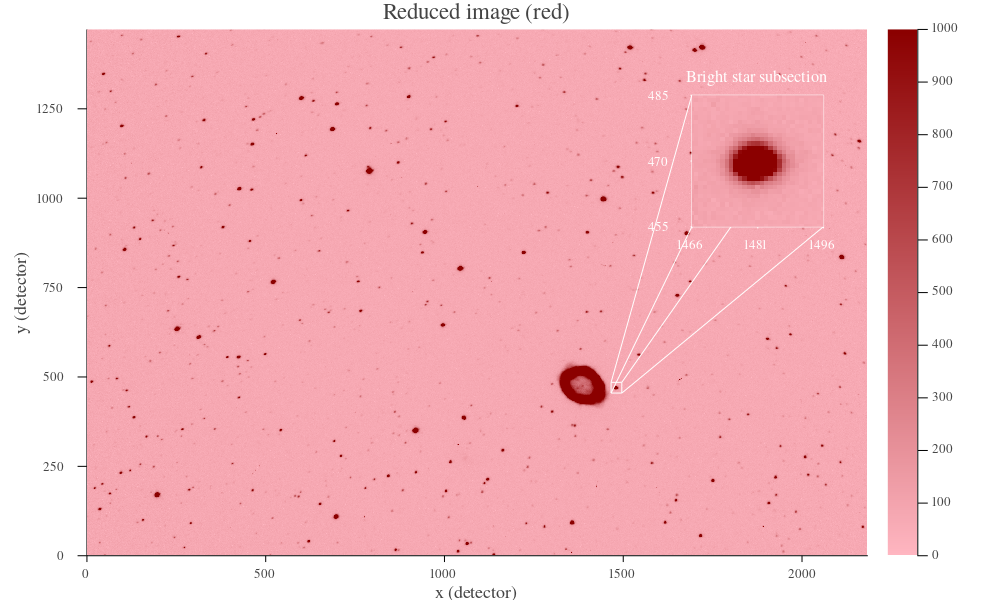

In [6]:
function makeFancyZoomPlot(filter,Δ=10,c=[1481,470]) #this makes a fancy inset zoom plot
    Δx = Δy = Δ #these are the coordinates of the center(ish) of a bright star, we're going to zoom in a range of 20 by 20 around it
    xRange = [c[1]-Δx,c[1]+Δx]; yRange = [c[2]-Δy,c[2]+Δy] # ^^^
    i = 2; C = :reds
    if filter == "green"
        i = 3; C = :greens
    elseif filter == "blue"
        i = 4; C = :blues
    end
    channel = makeImg(M57Reduced[i],"Reduced image ($filter)",true,C) #get the red reduced image
    p=plot(channel) #using a filtered one because they're darker
    function relative(p::Plots.Subplot, rx, ry) #this is a fancy function I've written that let's me plot in coordinates relative to parent plot
       xlims=Plots.xlims(p)
       ylims=Plots.ylims(p)
       return xlims[1]+rx*(xlims[2]-xlims[1]), ylims[1]+ry*(ylims[2]-ylims[1])
    end
    #draw a fancy zoom box around our star of interest
    cornersX=[xRange[1],xRange[2]]; cornersY=[yRange[1],yRange[2]]
    p=plot!([cornersX[1],cornersX[2]],[cornersY[1],cornersY[1]],c=:white,label="") #side 1
    p=plot!([cornersX[2],cornersX[2]],[cornersY[1],cornersY[2]],c=:white,label="") #side 2
    p=plot!([cornersX[1],cornersX[2]],[cornersY[2],cornersY[2]],c=:white,label="") #side 3
    p=plot!([cornersX[1],cornersX[1]],[cornersY[1],cornersY[2]],c=:white,label="") #side 4
    offset = 0.068 #account for space between labels and plot frame, estimated lazily by hand
    s1x,s1y = relative(p[1],5/8+2.2*offset,7/8-1/4); s2x,s2y = relative(p[1],5/8+1/4+offset,7/8) #first one gets 2.1 * offset because left side has xticklabels we need to go past, this jsut estimated by hand
    subCornersX=[s1x,s2x]; subCornersY=[s1y,s2y] #physical coordinates, box in top left
    p=plot!([subCornersX[1],cornersX[1]],[subCornersY[1],cornersY[1]],c=:white,label = "") #corner 1 -> corner 1
    p=plot!([subCornersX[2],cornersX[2]],[subCornersY[2],cornersY[2]],c=:white,label = "") #corner 2 -> corner 2
    p=plot!([subCornersX[1],cornersX[1]],[subCornersY[2],cornersY[2]],c=:white,label = "") #corner 3 -> corner 3
    p=plot!([subCornersX[2],cornersX[2]],[subCornersY[1],cornersY[1]],c=:white,label = "") #corner 4 -> corner 4
    #above we've drawn all the lines for the zoom box, below creates the actual plot within a plot (plotception) that's zoomed in on our star
    p=plot!(inset=(1,bbox(5/8,1/8,1/4,1/4)),legend=false,foreground_color_border=:white,foreground_color_axis=:white,
            foreground_color_text=:white,aspect_ratio=:equal,subplot=2,framestyle=:box,tickfontsize=8,
            title="Bright star subsection",titlefontcolor=:white,titlefontsize=10,xlims=(1,2*Δx+1),ylims=(1,2*Δy+1),
            xticks=([1,Δx+1,2*Δx+1],["$(c[1]-Δx)","$(c[1])","$(c[1]+Δx)"]),yticks=([1,Δy+1,2*Δy+1],["$(c[2]-Δy)","$(c[2])","$(c[2]+Δy)"])) #inset tells it to do plotception, bbox are relative to parent and goes like (x,y,xwidth,ywidth)
    p=heatmap!(p[2],M57Reduced[i][xRange[1]:xRange[2],yRange[1]:yRange[2]]',c=C,clims=(0,1000))#fill in our plotception plot with the actual heatmap
    p=plot(p,size=(1000,600))
    return p
end
redZoom = makeFancyZoomPlot("red",15); greenZoom = makeFancyZoomPlot("green",15); blueZoom = makeFancyZoomPlot("blue",15)
plot(redZoom)

In the red band when we zoom in we can see this bright star is centered around the coordinates (1481,470), but when we zoom in on those same coordinates in the other bands we can clearly see that same bright star has shifted! See the blue/green plots below:

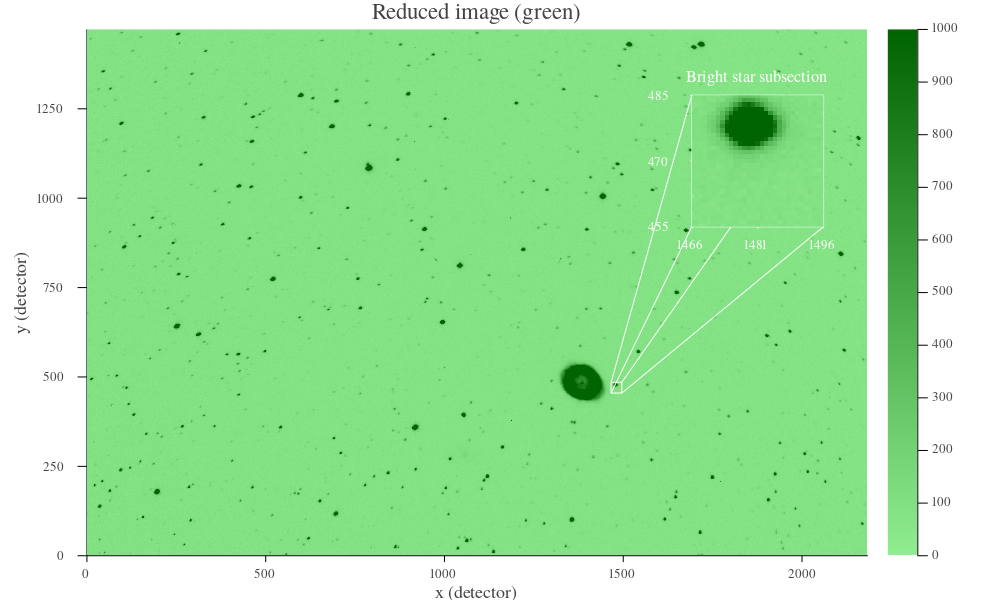

In [7]:
plot(greenZoom) #show the green one, looks like it's shifted up about 10 pixels and to the left one or two

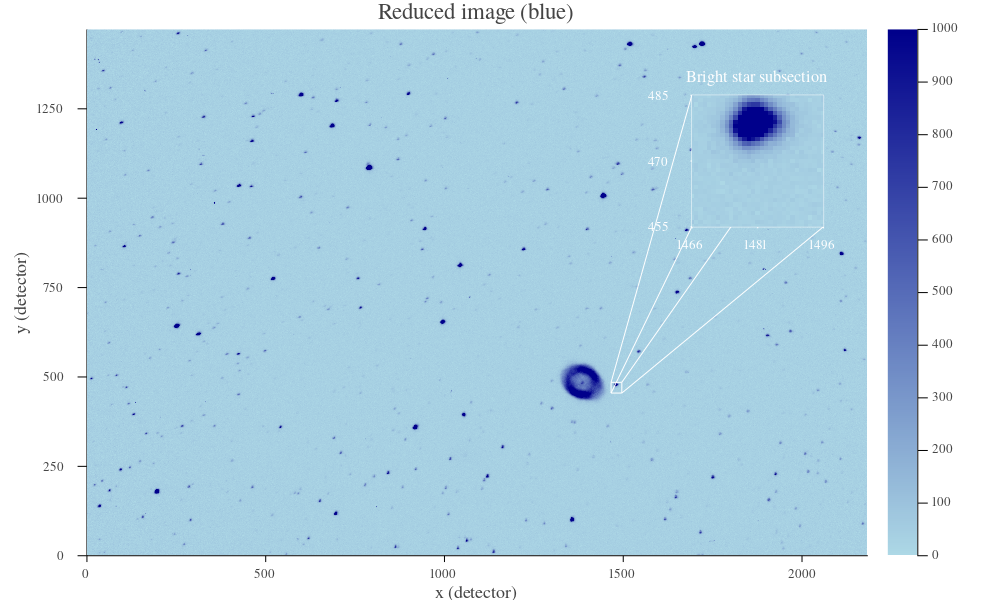

In [8]:
plot(blueZoom) #this one looks shifted up by about the same amount as the green one but looks fine in the x direction

Just by eyeballing the plots above it looks to me like (relative to red) the green and blue images are both shifted about 10 pixels up and the green one is shifted a few pixels to the right. We can code up this shift and make a test image to see how it looks:

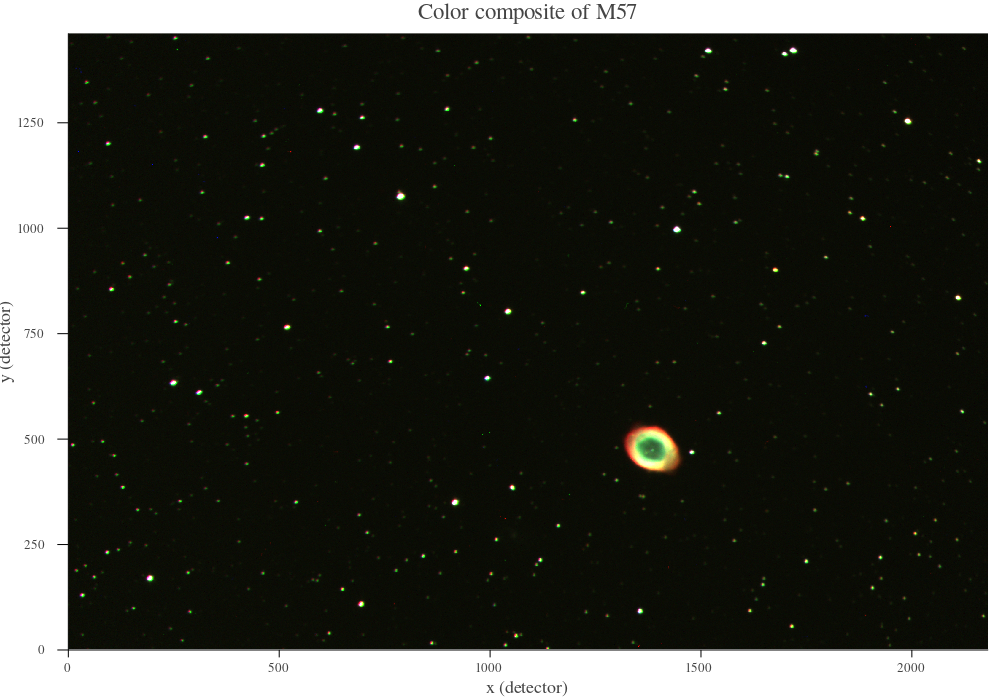

In [9]:
r,g,b = [M57Reduced[i] for i=2:4] 
Δx = 3; Δy = 10
newImg = zeros(3,size(r)[2]-Δy,size(r)[1]-Δx) #rgb,y,x -- needs to be smaller than original array because we're shifting things
for i=1:size(newImg)[1]
    for j=1:size(newImg)[3] 
        for k=1:size(newImg)[2] #k,j swap rotates below, no longer dividing by clear image, instead normalizing different way
            if i==1
                newImg[i,k,j]= r[j+Δx,k] #red not shifted at all
            elseif i==2
                newImg[i,k,j]= g[j,k+Δy]#green shifted by Δx, Δy
            else
                newImg[i,k,j]= b[j+Δx,k+Δy]#blue shited by Δy
            end
        end
    end
end
newImg = newImg./(maximum(newImg)/30) #/100 for overexposure to see galaxy
rgbCube = reverse(newImg,dims=2) #reverse it? yes, this works and matches orientation of "real" pictures (fixes y direction)
shape = size(rgbCube)
rgbCube = vec(rgbCube)
rgbCube[rgbCube.<0.0] .= 0.0; rgbCube[rgbCube.>1.0] .= 1.0
rgbCube = reshape(rgbCube,shape)
save("M57RGB.png",colorview(RGB,rgbCube))

img = FileIO.load("M57RGB.png")
endY = size(r)[2]-Δy
plot(img,title="Color composite of M57",xlabel="x (detector)",ylabel="y (detector)",size=(1000,700),
    aspect_ratio=:equal,xlims=(0,size(r)[1]-Δx),ylims=(0,size(r)[2]-Δy),
    yticks=([endY,endY-250,endY-500,endY-750,endY-1000,endY-1250],["0","250","500","750","1000","1250"]))

This looks a little better, and is pretty good for a "by eye" estimate, but let's see if we can do better with math! We can calculate the centroids of this anchor star in each of the images to better compute the shift between them:

In [10]:
function centroid(img,c,Δ) #get the centroid of a slice of an image
    Δx=Δy=Δ
    xRange = [c[1]-Δx,c[1]+Δx]; yRange = [c[2]-Δy,c[2]+Δy]
    x = range(c[1]-Δx,stop=c[1]+Δx,length=2*Δx+1); y = range(c[2]-Δy,stop=c[2]+Δy,length=2*Δy+1)
    sub=img[xRange[1]:xRange[2],yRange[1]:yRange[2]] #image subsection bounded by xRange, yRange
    xIntensity = [sum(sub[i,:]) for i=1:size(sub)[1]]; yIntensity = [sum(sub[:,i]) for i=1:size(sub)[2]] #get the intensity in just the x and y directions
    xCen = sum(xIntensity.*x)/sum(xIntensity); yCen = sum(yIntensity.*y)/sum(yIntensity) #calculate the centroids using weighted average formula
    return round(xCen), round(yCen) #return them rounded to nearest integer (pixel)
end
centroid(M57Reduced[2],[1480,470],20) #let's test one -- look, it matches the zoom plot!

(1480.0, 470.0)

In [11]:
centroid(M57Reduced[3],[1480,470],20) #green is shifted 1 left, 5 up

(1479.0, 475.0)

In [12]:
centroid(M57Reduced[4],[1480,470],20) #blue is shifted 6 up

(1480.0, 476.0)

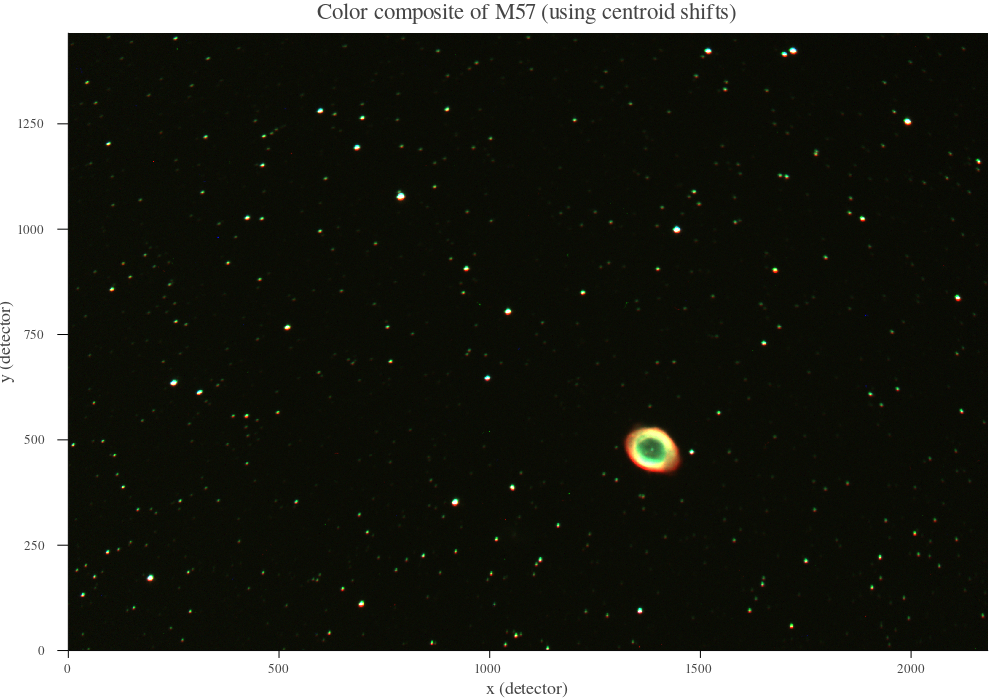

In [14]:
r,g,b = [M57Reduced[i] for i=2:4] 
Δx = 1; Δy = 6 #let's use new shifts identified above
newImg = zeros(3,size(r)[2]-Δy,size(r)[1]-Δx) #rgb,y,x -- needs to be smaller than original array because we're shifting things
for i=1:size(newImg)[1]
    for j=1:size(newImg)[3] 
        for k=1:size(newImg)[2] #k,j swap rotates below, no longer dividing by clear image, instead normalizing different way
            if i==1
                newImg[i,k,j]= r[j+Δx,k] #red not shifted at all
            elseif i==2
                newImg[i,k,j]= g[j,k+Δy-1]#green shifted left by Δx, up Δy-1
            else
                newImg[i,k,j]= b[j+Δx,k+Δy]#blue shited up by Δy
            end
        end
    end
end
newImg = newImg./(maximum(newImg)/30) # this controls the "exposure" -- /100 for overexposure to see galaxy
rgbCube = reverse(newImg,dims=2) #reverse it? yes, this works and matches orientation of "real" pictures (fixes y direction)
shape = size(rgbCube)
rgbCube = vec(rgbCube)
rgbCube[rgbCube.<0.0] .= 0.0; rgbCube[rgbCube.>1.0] .= 1.0
rgbCube = reshape(rgbCube,shape)
save("M57RGB.png",colorview(RGB,rgbCube))

img = FileIO.load("M57RGB.png")
endY = size(r)[2]-Δy
plot(img,title="Color composite of M57 (using centroid shifts)",xlabel="x (detector)",ylabel="y (detector)",size=(1000,700),
    aspect_ratio=:equal,xlims=(0,size(r)[1]-Δx),ylims=(0,size(r)[2]-Δy),yflip=true,
    yticks=([endY,endY-250,endY-500,endY-750,endY-1000,endY-1250],["0","250","500","750","1000","1250"]))

Still doesn't look perfect, but it's even better than it was before and is as close as we'll likely get with integer shifting the pixel values. As a final step, we'll code all this up in a Julia (.jl) file, wrapping the entire process in one big function that will allow us to generate the image from the data in one fell swoop. We then have a script that can automatically process images! My version of this is called `ImagingWorkshop.jl` and should be provided to you in the same folder you got this notebook from.

## Questions:

1. Explain (in a few sentences) how a telescope works. What are the most important things to know about it?

2. Explain (in a few sentences) how a CCD (the fancy camera) works. How does using a camera change the observing experience?

3. Discuss the differences in the reduced image vs. the raw image. Why is it important to do this? What kinds of errors are we correcting for?

4. Which would you select a longer exposure time for: Saturn or the Ring Nebula? Briefly explain your answer in terms of the technical limitations of the CCD.

5. What is the Ring Nebula? Connect it with what we've been talking about in class.

